## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))

    x = keras.layers.Dense(dense[0], activation = 'relu')(inputs)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(1, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()


def gen_data(mean = 0, var = 1, SIZE = 20000):
    
    
    
    g = np.random.normal(mean,var, SIZE)
    a = g +np.random.normal(mean,var, SIZE)
    b = g + np.random.normal(mean, var, SIZE)
    c = g +np.random.normal(mean, var, SIZE)
    d = g +np.random.normal(mean, var, SIZE)
    
    e = g + np.random.normal(mean, var, SIZE)
    f = g + np.random.normal(mean, var, SIZE)
    
    #g = np.rint(g)
    return pd.DataFrame({'a' : a,'b' : b, 'c' : c, 'd' : d,'e' : e,'f':f, 'g':g})

def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    #tetrad.run(algoId = 'fges-mb', targetName = 'g', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
    #       structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
    #       completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)


    return tetrad.getTetradGraph()



from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =20
model_layers = [2048, 2048, 512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/f' + str(i))

print(models, model_names)

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'gfci', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a
full_conx = get_pairs(['a', 'b', 'c', 'd', 'e', 'f', 'g'])
forced_conx = set({('g','a'), ('g','b'),('g','c'),('g','d'),('g','e'),('g','f'), })
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )



inputs = ['a','b','c','d','e','f']
target = ['g']


df = gen_data()
X = df[inputs].values
y = df[target].values

val_df = gen_data(SIZE = 2000)
x_val = df[inputs].values
y_val = df[target].values



[[2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512], [2048, 2048, 512]] ['temp/f0', 'temp/f1', 'temp/f2', 'temp/f3', 'temp/f4', 'temp/f5', 'temp/f6', 'temp/f7', 'temp/f8', 'temp/f9', 'temp/f10', 'temp/f11', 'temp/f12', 'temp/f13', 'temp/f14', 'temp/f15', 'temp/f16', 'temp/f17', 'temp/f18', 'temp/f19']


In [17]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs))
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.SGD(lr = 0.001, momentum = 0.9, ), loss='mean_squared_error', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/f0
Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 4s 177us/step - loss: 0.1701 - mean_squared_error: 0.1701 - val_loss: 0.1525 - val_mean_squared_error: 0.1525

Epoch 00001: val_loss improved from inf to 0.15249, saving model to temp/f0
Epoch 2/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.1527 - mean_squared_error: 0.1527 - val_loss: 0.1519 - val_mean_squared_error: 0.1519

Epoch 00002: val_loss improved from 0.15249 to 0.15192, saving model to temp/f0
Epoch 3/20
20000/20000 [==============================] - 3s 156us/step - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.1523 - val_mean_squared_error: 0.1523

Epoch 00003: val_loss did not improve from 0.15192
Epoch 4/20
20000/20000 [==============================] - 3s 160us/step - loss: 0.1512 - mean_squared_error: 0.1512 - val_loss: 0.1500 - val_mean_squared_error: 0.1500

Epoch 00004: val_loss improved from 0.15192 to 0.14996, sav

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 151us/step - loss: 0.1711 - mean_squared_error: 0.1711 - val_loss: 0.1527 - val_mean_squared_error: 0.1527

Epoch 00001: val_loss improved from inf to 0.15274, saving model to temp/f4
Epoch 2/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.1529 - mean_squared_error: 0.1529 - val_loss: 0.1524 - val_mean_squared_error: 0.1524

Epoch 00002: val_loss improved from 0.15274 to 0.15237, saving model to temp/f4
Epoch 3/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.1528 - mean_squared_error: 0.1528 - val_loss: 0.1516 - val_mean_squared_error: 0.1516

Epoch 00003: val_loss improved from 0.15237 to 0.15161, saving model to temp/f4
Epoch 4/20
20000/20000 [==============================] - 3s 136us/step - loss: 0.1519 - mean_squared_error: 0.1519 - val_loss: 0.1509 - val_mean_squared_error: 0.1509

Epoch 00004: val_loss improved from 0.

Train on 20000 samples, validate on 20000 samples
Epoch 1/20
20000/20000 [==============================] - 3s 154us/step - loss: 0.1722 - mean_squared_error: 0.1722 - val_loss: 0.1520 - val_mean_squared_error: 0.1520

Epoch 00001: val_loss improved from inf to 0.15203, saving model to temp/f8
Epoch 2/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.1524 - mean_squared_error: 0.1524 - val_loss: 0.1517 - val_mean_squared_error: 0.1517

Epoch 00002: val_loss improved from 0.15203 to 0.15174, saving model to temp/f8
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.1513 - val_mean_squared_error: 0.1513

Epoch 00003: val_loss improved from 0.15174 to 0.15131, saving model to temp/f8
Epoch 4/20
20000/20000 [==============================] - 3s 141us/step - loss: 0.1517 - mean_squared_error: 0.1517 - val_loss: 0.1510 - val_mean_squared_error: 0.1510

Epoch 00004: val_loss improved from 0.

20000/20000 [==============================] - 3s 139us/step - loss: 0.1513 - mean_squared_error: 0.1513 - val_loss: 0.1505 - val_mean_squared_error: 0.1505

Epoch 00006: val_loss did not improve from 0.15000
Epoch 7/20
20000/20000 [==============================] - 3s 139us/step - loss: 0.1499 - mean_squared_error: 0.1499 - val_loss: 0.1494 - val_mean_squared_error: 0.1494

Epoch 00007: val_loss improved from 0.15000 to 0.14937, saving model to temp/f11
Epoch 8/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.1500 - mean_squared_error: 0.1500 - val_loss: 0.1501 - val_mean_squared_error: 0.1501

Epoch 00008: val_loss did not improve from 0.14937
Epoch 9/20
20000/20000 [==============================] - 3s 134us/step - loss: 0.1503 - mean_squared_error: 0.1503 - val_loss: 0.1488 - val_mean_squared_error: 0.1488

Epoch 00009: val_loss improved from 0.14937 to 0.14878, saving model to temp/f11
Epoch 10/20
20000/20000 [==============================] - 3s 138us/ste

20000/20000 [==============================] - 3s 139us/step - loss: 0.1525 - mean_squared_error: 0.1525 - val_loss: 0.1522 - val_mean_squared_error: 0.1522

Epoch 00002: val_loss improved from 0.15233 to 0.15221, saving model to temp/f16
Epoch 3/20
20000/20000 [==============================] - 3s 138us/step - loss: 0.1519 - mean_squared_error: 0.1519 - val_loss: 0.1515 - val_mean_squared_error: 0.1515

Epoch 00003: val_loss improved from 0.15221 to 0.15147, saving model to temp/f16
Epoch 4/20
20000/20000 [==============================] - 3s 133us/step - loss: 0.1518 - mean_squared_error: 0.1518 - val_loss: 0.1508 - val_mean_squared_error: 0.1508

Epoch 00004: val_loss improved from 0.15147 to 0.15075, saving model to temp/f16
Epoch 5/20
20000/20000 [==============================] - 3s 137us/step - loss: 0.1508 - mean_squared_error: 0.1508 - val_loss: 0.1506 - val_mean_squared_error: 0.1506

Epoch 00005: val_loss improved from 0.15075 to 0.15062, saving model to temp/f16
Epoch 6/20


20000/20000 [==============================] - 3s 147us/step - loss: 0.1504 - mean_squared_error: 0.1504 - val_loss: 0.1488 - val_mean_squared_error: 0.1488

Epoch 00009: val_loss improved from 0.14899 to 0.14877, saving model to temp/f19
Epoch 10/20
20000/20000 [==============================] - 3s 148us/step - loss: 0.1496 - mean_squared_error: 0.1496 - val_loss: 0.1487 - val_mean_squared_error: 0.1487

Epoch 00010: val_loss improved from 0.14877 to 0.14874, saving model to temp/f19
Epoch 11/20
20000/20000 [==============================] - 3s 147us/step - loss: 0.1494 - mean_squared_error: 0.1494 - val_loss: 0.1489 - val_mean_squared_error: 0.1489

Epoch 00011: val_loss did not improve from 0.14874
Epoch 00011: early stopping


In [18]:
nb_test = 2000
metrics_dicts = []
for m in models:
    metrics_dicts.append(defaultdict(list))


#means = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
#variances = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
means = [0, 1, 2]
variances = [1,2,3]


# ok at this point we need to check the model on various variances and means
for m in means:
    for v in variances:
        print(m,v)
        #t0 = time.time()
        perturbed_df = gen_data(mean =m, var = v, SIZE = nb_test)
        y_test2 = perturbed_df[target]
        x_test2 = perturbed_df[inputs]
        #t1 = time.time()
        #print("Time for gen_data = ", t1 - t0)
        for idx, model_name in enumerate(model_names):
            #t0 = time.time()
            if type(models[idx]) is list:
                keras.backend.clear_session()
                model = load_model(model_name)
            else:
                model = models[idx]
            #t1 = time.time()
            #print("Time to load model = ", t1 - t0)
            
            y_pred2 = model.predict(x_test2)
            metrics_dicts[idx][str(m) + '_' + str(v)].append(mean_squared_error(y_test2, y_pred2))

            test_df2 = pd.DataFrame(x_test2, columns = inputs)
            test_targets2 = pd.DataFrame(model.predict(x_test2), columns = target)
            test_df2 = test_df2.join(test_targets2)
'''
            setA = get_MB(get_CG(perturbed_df, tetrad), 'g', pc)
            if setA != {'f'}:
                print("Error in SETA markov blanket")
                #setA = {'f'}
            setC = get_MB(get_CG(test_df2, tetrad), 'g', pc)

            if setA != setC:
                causal_dicts[idx][str(m) + '_' + str(v)].append(1)
            else:
                causal_dicts[idx][str(m) + '_' + str(v)].append(0)

'''




0 1
0 2
0 3
1 1
1 2
1 3
2 1
2 2
2 3


'\n            setA = get_MB(get_CG(perturbed_df, tetrad), \'g\', pc)\n            if setA != {\'f\'}:\n                print("Error in SETA markov blanket")\n                #setA = {\'f\'}\n            setC = get_MB(get_CG(test_df2, tetrad), \'g\', pc)\n\n            if setA != setC:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(1)\n            else:\n                causal_dicts[idx][str(m) + \'_\' + str(v)].append(0)\n\n'

Times =  0
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8068.697388401631
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8007.619629694089
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8039.905462753027
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8104.680482807253
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7954.607235512097
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8026.416837234839
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8083.087637573258
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8018.260776361225
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7968.333852895309
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7978.7526679722405
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8099.786935197061
['g --> a', 'g --> b', 'g --> c', 'g --> d

['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8529.319104735989
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8583.717953555471
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8535.549561082253
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8546.660127710295
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8598.36441815911
Times =  5
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8077.345458052634
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7999.766787123133
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8021.253063652215
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-8099.440117639254
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7918.591512160429
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7995.203832958971
['g --> a', 'g --> b', 'g --> c', 'g --> d',

['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7917.434002842431
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7854.073552528583
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7890.844376062789
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7806.875474920823
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7846.901946321816
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7826.3161164756175
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7864.230013048922
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7806.846096150699
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7833.636252958606
['g --> a', 'g --> b', 'g --> c', 'g --> d', 'g --> e', 'g --> f']
-7877.145379891813
Model_name =  temp/f0 Violations =  0.0
Average_violations =  -8250.665256138049 276.8564947803288
MSE =  0.1501119686432111 0.005126811776

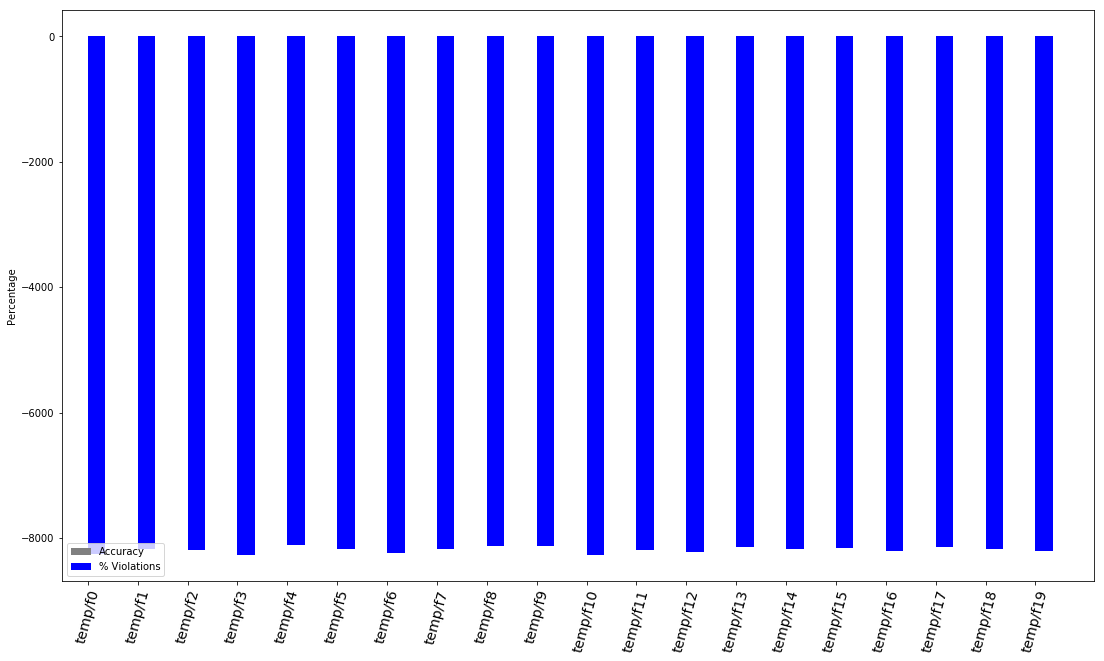

temp/f0
Area under surface (rectangular approx) =  14.800153953508506
Violations =  0.0
Average_violations =  -8250.665256138049
MSE =  0.1501119686432111
temp/f1
Area under surface (rectangular approx) =  15.066033708142987
Violations =  0.0
Average_violations =  -8173.208319313283
MSE =  0.1494491838218994
temp/f2
Area under surface (rectangular approx) =  14.096358398877621
Violations =  0.0
Average_violations =  -8190.497734223197
MSE =  0.14882245270453537
temp/f3
Area under surface (rectangular approx) =  14.490292436096837
Violations =  0.0
Average_violations =  -8274.923311778772
MSE =  0.14941568856131968
temp/f4
Area under surface (rectangular approx) =  13.521597162095938
Violations =  0.0
Average_violations =  -8115.760319770294
MSE =  0.1489880414674386
temp/f5
Area under surface (rectangular approx) =  13.480792223527494
Violations =  0.0
Average_violations =  -8179.76662163604
MSE =  0.1482893595331408
temp/f6
Area under surface (rectangular approx) =  15.138905931302158

In [19]:
#the number of times to sample
times = 10
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    y_test = df_test[target].values
    #bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(model.predict(x_test), columns = target)
        test_df = test_df.join(test_targets)
       
        
    
        mean[idx][t] = mean_squared_error(y_test, model.predict(x_test)) 
        
        bic_pred = get_bic(test_df,prior)
        
        #bic_pred = get_bic(df_test.join(pd.DataFrame(model.predict(x_test), columns = ['target'])), prior)
        
        print(tetrad.getEdges())
        print(bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
print(np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))    

bar_plot(model_names, 
         np.array(metric), 
         np.array(metric_err), 
         np.array(viol), 
         np.array(viol_err))


def heat_plot(x,y,z, xlab = 'Mean', ylab = 'Variance', clim_low = 0, clim_high = 1):
    fig, ax = plt.subplots()

    cax = ax.scatter(x, y, c=z, s=450, edgecolor='')
    cax.set_clim(clim_low, clim_high)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    plt.colorbar(cax)
    plt.show()

    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    print(model_names[i])
    x = []
    y = []
    z = []
    
    
    rectangular_approx = 0
    for k, v in metrics_dicts[i].items():
        x.append(float(k.split('_')[0]))
        y.append(float(k.split('_')[-1]))
        z.append(np.mean(v))
        rectangular_approx += np.mean(v)
    print("Area under surface (rectangular approx) = ", rectangular_approx)
    print("Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]))   
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(rectangular_approx)


-0.6385023179646593


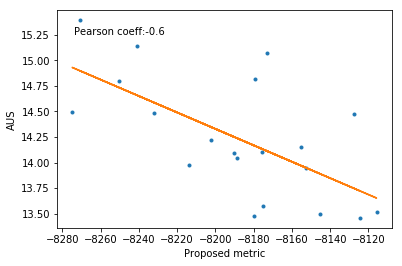

-0.6017031908445655


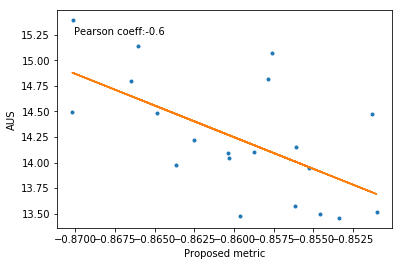

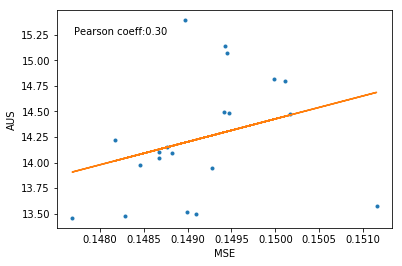

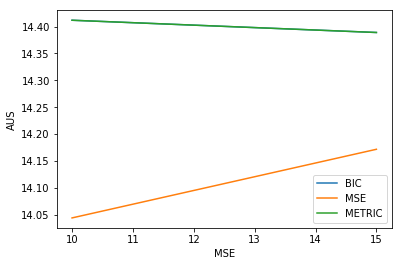

-0.6017031908445655

In [20]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text


print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()


METRIC = -(VIO/np.max(VIO)) + np.array(MSE)
print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Proposed metric")
ax.set_ylabel("AUS")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low)) 
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("AUS")
plt.show()  
pearsonr(METRIC,AUS)[0]